In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 1. Divisione del dataset in train e test

In [98]:
df = pd.read_csv('../datasets/cleaned_dataset.csv')

X = df.copy()
y = X.pop('fake')

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

## Addestramento senza iperparametri

In [105]:
# Istanziazione del classificatore
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# singole metriche in quanto report tende ad arrotondare per eccesso
print(f'accuracy_score (test set): {accuracy_score(y_test, y_pred)}')
print(f'precision_score (test set): {precision_score(y_test, y_pred)}')
print(f'recall_score (test set): {recall_score(y_test, y_pred)}')
print(f'f1_score (test set): {f1_score(y_test, y_pred)}')

accuracy_score (test set): 0.9995022399203584
precision_score (test set): 0.9990069513406157
recall_score (test set): 1.0
f1_score (test set): 0.9995032290114257


## 2. Grid Search Cross Validation

In [99]:
# Griglia dei parametri
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20]
}

rfc = RandomForestClassifier()

In [100]:
%%time
# stampa il tempo di esecuzione
# Stampiamo i migliori parametri
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)
grid_search.best_params_

CPU times: total: 922 ms
Wall time: 20.1 s


{'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}

In [101]:
#Vediamo come si comporta nelle diverse combinaizoni di parametri
cvres = grid_search.cv_results_

for i, (accuracy, params) in enumerate(zip(cvres["mean_test_score"], cvres["params"])):
    print(f"Iterazione {i}: Accuracy {accuracy}, Parametri {params}")

Iterazione 0: Accuracy 0.9977590255447545, Parametri {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Iterazione 1: Accuracy 0.9975101144340563, Parametri {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Iterazione 2: Accuracy 0.9976348023270942, Parametri {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
Iterazione 3: Accuracy 0.997634492543509, Parametri {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
Iterazione 4: Accuracy 0.9976346474353015, Parametri {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
Iterazione 5: Accuracy 0.9975101144340563, Parametri {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
Iterazione 6: Accuracy 0.9976346474353017, Parametri {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}
Iterazione 7: Accuracy 0.9977591804365469, Parametri {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}


## 3. Feature Importances

In [60]:
df_feature_importances = pd.DataFrame({
    'featureImportance': grid_search.best_estimator_.feature_importances_,
    'attribute': X_train.columns
})

df_feature_importances_sorted = df_feature_importances.sort_values(by='featureImportance', ascending=False)
df_feature_importances_sorted.reset_index(inplace=True, drop=True)
df_feature_importances_sorted

,featureImportance,attribute
0,0.275459,followerCount
1,0.164691,heartCount
2,0.163561,followingCount
3,0.096940,videoCount
4,0.079771,nicknameLength
5,0.075811,diggCount
6,0.041152,signatureLength
7,0.034955,nicknameNumSpecialCharacters
8,0.030574,openFavorite
9,0.020273,uniqueIdLength


## 4. Metriche del modello migliore

In [102]:
rfc_final = grid_search.best_estimator_
y_pred = rfc_final.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

# singole metriche in quanto report tende ad arrotondare per eccesso
print(f'accuracy_score (test set): {accuracy_score(y_test, y_pred)}')
print(f'precision_score (test set): {precision_score(y_test, y_pred)}')
print(f'recall_score (test set): {recall_score(y_test, y_pred)}')
print(f'f1_score (test set): {f1_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1003
           1       1.00      1.00      1.00      1006

    accuracy                           1.00      2009
   macro avg       1.00      1.00      1.00      2009
weighted avg       1.00      1.00      1.00      2009

accuracy_score (test set): 0.9990044798407167
precision_score (test set): 0.9990059642147118
recall_score (test set): 0.9990059642147118
f1_score (test set): 0.9990059642147118


### 4.1 Learning Curve

In [104]:
history = grid_search.best_estimator_.model.history

# Traccia la perdita nel corso delle epoche
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

AttributeError: 'RandomForestClassifier' object has no attribute 'history'

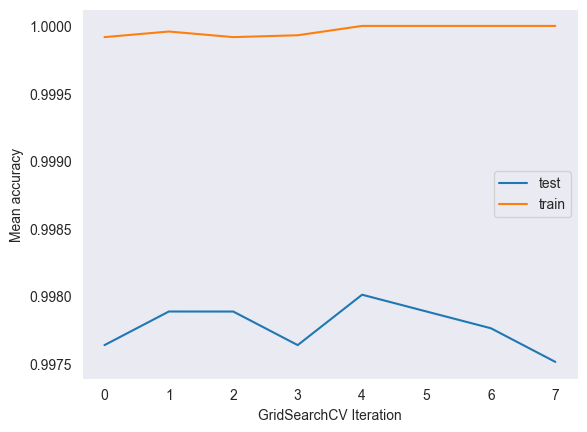

In [80]:
test_scores = cvres['mean_test_score']
train_scores = cvres['mean_train_score']

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.xlabel('GridSearchCV Iteration')
plt.ylabel('Mean accuracy')
plt.legend(loc='best')
plt.grid(visible=False)
plt.show()

### 4.2 Matrice di confusione

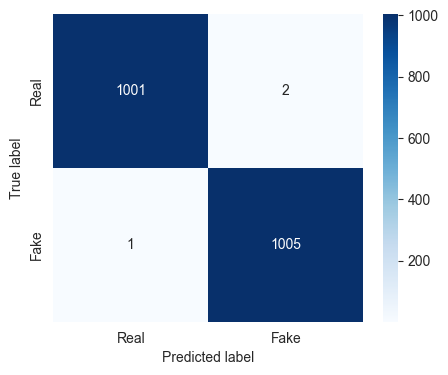

In [62]:
cm = confusion_matrix(y_test, y_pred)
class_names = ['Real', 'Fake']

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### 4.3 Roc Curve

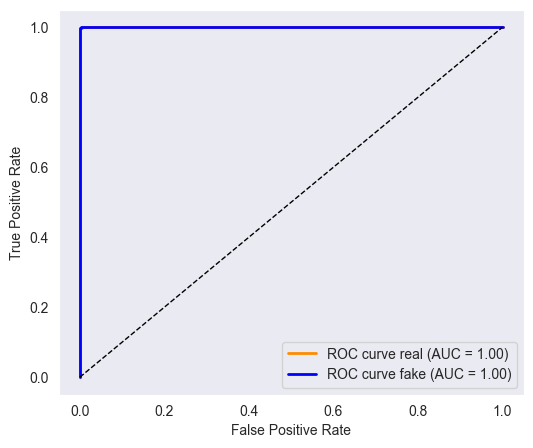

In [63]:
y_proba = rfc_final.predict_proba(X_test)

# Calcolo della curva ROC per la classe 'real', 1 - y_test fa in modo che sia considerata come classe true
fpr_real, tpr_real, _ = roc_curve(1 - y_test, y_proba[:, 0])
roc_auc_real = auc(fpr_real, tpr_real)

# Calcolo della curva ROC per la classe 'fake'
fpr_fake, tpr_fake, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc_fake = auc(fpr_fake, tpr_fake)

plt.figure(figsize=(6, 5))
plt.plot(fpr_real, tpr_real, color='darkorange', lw=2, label=f'ROC curve real (AUC = {roc_auc_real:.2f})')
plt.plot(fpr_fake, tpr_fake, color='blue', lw=2, label=f'ROC curve fake (AUC = {roc_auc_fake:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(visible=False)
plt.legend()
plt.show()